In [80]:
import numpy as np
import pandas as pd
import math
from datetime import datetime
import matplotlib.pyplot as plt

### Load Justice-centered data into pandas df

In [347]:
trainX = pd.read_csv('../data/trainX_justice.csv')
trainY = pd.read_csv('../data/trainY_justice.csv')
testX = pd.read_csv('../data/testX_justice.csv')
testY = pd.read_csv('../data/testY_justice.csv')

### Variables (from preprocessing)

In [348]:
# column names by category
id_variables_to_drop = [
    u'justiceName', #Name and unique ID
    ]
id_variables_to_keep = [
    u'justice',  #Name and unique ID
    u'caseId', u'docketId', u'caseIssuesId', u'voteId',
    u'usCite', u'sctCite', u'ledCite', u'lexisCite',
    u'docket']
    
bg_variables = [
    u'caseName', u'petitioner', u'petitionerState',
    u'respondent', u'respondentState', u'jurisdiction',
    u'adminAction', u'adminActionState', u'threeJudgeFdc',
    u'caseOrigin', u'caseOriginState', u'caseSource',
    u'caseSourceState', u'lcDisagreement', u'certReason',
    u'lcDisposition', u'lcDispositionDirection',
]

chrono_include = [u'naturalCourt', u'chief']
chrono_donotinclude = [u'dateDecision', u'decisionType', u'term',
                       u'dateArgument', u'dateRearg']
chrono_variables = chrono_include + chrono_donotinclude

substantive_variables = [
    u'issue', u'issueArea', u'decisionDirection',
    u'decisionDirectionDissent', u'authorityDecision1',
    u'authorityDecision2', u'lawType', u'lawSupp', u'lawMinor']

outcome_variables = [
    u'declarationUncon', u'caseDisposition',
    u'caseDispositionUnusual', u'partyWinning', u'precedentAlteration',  
    u'firstAgreement', u'secondAgreement']

voting_variables = [u'voteUnclear', u'majOpinWriter', u'majOpinAssigner',
                    u'splitVote', u'majVotes', u'minVotes',  u'vote', u'opinion',
                    u'direction', u'majority']


## Decide on outcome vector

## One-hot encode select categorical variables
#### + impute nulls

In [349]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.sparse import csr_matrix, hstack

class Categorical(object):
    def __init__(self, df, outcomes, ohe_threshold = 1000):
        self.names = df['justiceName']
        #Drop name vector (redundant)
        self.arr = df[id_variables_to_keep + bg_variables + chrono_include + substantive_variables].copy()
        self.arr = self.arr.fillna(-1) # Impute values
        self.outcomes = outcomes.copy()
        self.outcomes = self.outcomes.fillna(-1) #Impute values
        # Select the categorical features to OHE
        ohe_vars = []
        other_vars = []
        for c in self.arr.columns:
            u =  len(self.arr[c].unique())
            if u < ohe_threshold:
#                 prZint "{0}: {1} unique".format(c, len(self.arr[c].unique()))
                ohe_vars.append(c)
            else:
                other_vars.append(c)
        
        self.n_samples, self.n_features = self.arr.shape
        self.n_cat_features = len(ohe_vars)
        self.ohe_vars = ohe_vars
        self.other_vars = other_vars
        self.arr = pd.concat([self.arr[other_vars], self.arr[ohe_vars]], axis=1)
        self.columns = other_vars + ohe_vars
        #Label Encode select categorical variables
        self.LE()
        self.other = self.arr[other_vars].copy() #ID and other features
        self.cat = self.arr[ohe_vars].copy() #Categorical features
        self.cat_ohe = self.cat.copy() #OHE categorical features
        self.n_justices = len(self.cat['justice'].unique())
        #Label Encode the outcome variables
        self.LE_Outcomes()
        #OHE the categorical data
        self.OHE()
        
        
    def LE(self):
        '''Label Encode ALL variables (to give reasonable feautures) '''  
        le = {}  #keep le global so we may inverse_transform if necessary
        for c in self.columns: #self.ohe_vars: #text_cols:
            le[c] = LabelEncoder()
            self.arr.loc[:,c] = le[c].fit_transform(self.arr[c])
        self.le = le # label encoder (useful for reverse transforming also)
        
    def LE_Outcomes(self):
        le = {}
        for c in self.outcomes.columns:
            le[c] = LabelEncoder()
            self.outcomes.loc[:,c] = le[c].fit_transform(self.outcomes[c])
                
        self.le_out = le
        
    def OHE(self):
        self.ohe = OneHotEncoder()
        self.ohe.fit(self.cat)
        self.cat_ohe =  self.ohe.transform(self.cat) 
    
    
    def orig_cat(self): # Not important since I cache the values, but keep for possible future functions
        '''Returns the original array of the OHE encoded csr array
            (requires the original one-hot encoder fit to the dataset) '''
        return np.array([self.ohe.active_features_[col] for col in 
                            self.cat.sorted_indices().indices]).reshape(self.n_samples, self.n_cat_features) \
                                - self.ohe.feature_indices_[:-1]
        
    def getValue(self, col):
        '''Return the original value for the label-encoded variable'''
        if col not in self.columns:#self.ohe_vars:
            return None
        le = self.le[self.columns.index(col)]
        return le.inverse_transform(self.cat[col])

    def isolate_justice(self, ID, deep=False, ind=True):
        '''Return sparse array for data for a single justice '''
        
        #Check if ID is a legal label-encodded justice id
        if ID < 0 or ID >= self.n_justices:
            print "Error: Not a legal justice ID"
            return None
        
        if ind:
            return self.cat.loc[self.cat['justice'] == ID].index
        elif deep:
            return self.cat.loc[self.cat['justice'] == ID].copy()
        else:
            return self.cat.loc[self.cat['justice'] == ID]
        
    def merge_Xmatrices(self, rows):
        return hstack((csr_matrix(self.other.values[rows,:]), self.cat_ohe[rows,:]))
    
#     def merge_Ymatrices(self, rows):
#         return hstack((csr_matrix(self.other.values[rows,:]), self.cat_ohe[rows,:]))
    
    def justice_X(self, ID):
        return self.merge_Xmatrices(rows=self.isolate_justice(ID))
    
    def justice_Y(self, ID):
        return self.outcomes.values[self.isolate_justice(ID), :]

    
def index_outcome(arr, col, columns):
    return arr[:, list(columns).index(col)]
        

## Create a categorical object

In [350]:
trainX_Cat = Categorical(df = trainX, outcomes = trainY)

## Cluster justices into 2 groups based on likelihood to side with majority

In [369]:
from sklearn.cluster import KMeans

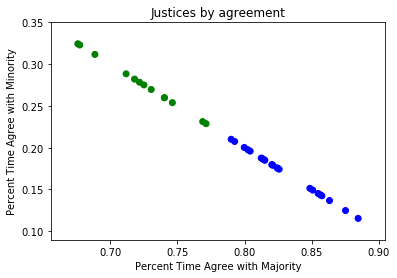


Green (relatively more frequently side with majority):
EKagan WHRehnqu WEBurger WBRutled TMarshal TCClark SSotomay SMinton SGBreyer SFReed AJGoldbe RBGinsbu RHJackso DHSouter PStewart JPSteven JGRobert HLBlack FMVinson FFrankfu EWarren SAAlito JHarlan2 

Blue (relatively more likely to vote minority):
AFortas SDOConno LFPowell WJBrenna HHBurton HABlackm FMurphy WODougla CThomas CEWhitta BRWhite AScalia AMKenned


In [351]:
def maj_min_norm(cat, justiceID):
    '''Return 2D vector representation where dim_0 is the percent time 
        voting with majority and dim_1 is percent voting with minority'''
    j = cat.justice_Y(justiceID)
    maj_min = index_outcome(j,'majority', trainY.columns)
#     print np.unique(maj_min)
    n = maj_min.shape[0]
    total = np.sum(maj_min == 2)
    return [float(total)/n, float(n-total)/n]
    

justices = np.array([maj_min_norm(trainX_Cat, i) for i in np.unique(trainX_Cat.arr['justice'].values)])

kmeans = KMeans(n_clusters=2, random_state=0).fit(justices)
colors = np.where(kmeans.labels_ == 1, 'b', 'g')
# Group by 
names =  np.unique(trainX_id['justiceName'])
groups = np.array([[n, 1] if c else [n, 0] for (c, n) in zip(kmeans.labels_ == 1,names)])
groups =  groups[groups[:, 1].argsort()]

n_0 = np.sum(groups[:, 1] == '0')
n_1 = np.sum(groups[:, 1] == '1')
minor = np.empty((n_0, 2), dtype=('string', float))
major = np.empty((n_1, 2), dtype=('string', float))

j =  k = 0
for i in range(groups.shape[0]):
    if groups[i, 1] == '0':
        minor[j] = groups[i]
        j = j + 1
    elif groups[i, 1] == '1':
        major[k] = groups[i]
        k = k + 1
    

plt.scatter(justices[:, 0], justices[:, 1], c=colors)
plt.title('Justices by agreement')
plt.xlabel('Percent Time Agree with Majority')
plt.ylabel('Percent Time Agree with Minority')
plt.show()

print "\nGreen (relatively more frequently side with majority):"
for name, label in zip(major[:,0], major[:,1]):
    print name,
print "\n\nBlue (relatively more likely to vote minority):"
for name, label in zip(minor[:,0], minor[:,1]):
    print name,

## Now what

Cluster based on issues?

In [366]:
# Create a dictionary to easily get name
name_to_id = { name: l for (name, l) in zip(trainX_Cat.names.unique(), trainX_Cat.arr['justice'].unique())}
id_to_name = { l: name for (name, l) in zip(trainX_Cat.names.unique(), trainX_Cat.arr['justice'].unique())}
def ideology_vector(cat, justiceID, vecSize):
    j_y = cat.justice_Y(justiceID)
    j_ind = cat.isolate_justice(justiceID)
    bias = index_outcome(j_y, 'direction', trainY.columns) # normalized lean (conservative | liberal) in this case
    issue = np.array((cat.cat['issueArea'].values)[j_ind]) # IssueArea for the case
    bias[np.where(bias == 2)] = -1 # Recode s.t. -1 ~ liberal, 0, nan, 1 ~ conservative
    v = np.zeros(vecSize, dtype=float)
    t = np.zeros(vecSize, dtype=float)
    # Sum the total values
    for i in range(bias.shape[0]):
        v[issue[i]] = v[issue[i]] + bias[i]
        t[issue[i]] = t[issue[i]] + 1

    for i in range(vecSize):
        if t[i] > 0:
            v[i] = v[i] / t[i] # normalize by totals for each subject area
    return v # v is then an "ideology vector" we may use to cluster justices


n_areas = trainX_Cat.le['issueArea'].classes_.shape[0] #Total general issue areas
j_ids = np.unique(trainX_Cat.arr['justice'].values)
# names = trainX_Cat.le['justiceName'].inverse_tranform(j_ids)
justices = np.array([ideology_vector(trainX_Cat, i, n_areas) for i in j_ids])  
j_with_names = {id_to_name[l]: vec for (l, vec) in zip(j_ids, justices)}
    

In [387]:
km = KMeans(n_clusters=4, random_state=0).fit(justices)
# colors = np.where(kmeans.labels_ == 1, 'b', 'g')
labels = km.labels_
n = labels.shape
colors = np.empty(n, dtype=str)
for i in range(n[0]):
    if labels[i] == 0:
        colors[i] = 'g'
    elif labels[i] == 1:
        colors[i] = 'b'
    elif labels[i] == 2:
        colors[i] = 'r'
    else:
        colors[i] = 'm'


## Project onto top 2 principal components

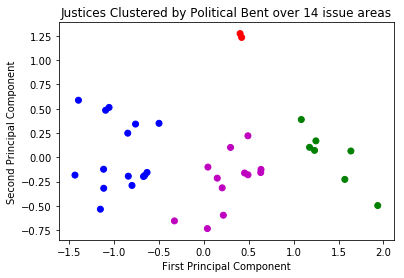

In [391]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(justices)

justices_pca = pca.transform(justices)


plt.scatter(justices_pca[:,0], justices_pca[:, 1], c=colors)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Justices Clustered by Political Bent over 14 issue areas')
plt.show()

In [342]:
for name, vals in zip(names, justices_pca):
    print "Justice {0}: {1}, {2}".format(name, vals[0], vals[1])

Justice 0: 1.08558086748, 0.389014718452
Justice 1: -1.09234671578, 0.484776786002
Justice 2: 0.217864108182, -0.596827043203
Justice 3: 1.6373529285, 0.0647278427363
Justice 4: 0.404327511853, 1.27457988359
Justice 5: -0.326294426791, -0.655464122196
Justice 6: 0.421683859925, 1.2350390119
Justice 7: -0.845723097329, 0.248513564856
Justice 8: -1.39439728309, 0.587935637609
Justice 9: 0.0464088780901, -0.100920471061
Justice 10: -1.05367827135, 0.513797867991
Justice 11: 1.56984901728, -0.227787203064
Justice 12: 0.0402921915457, -0.734601610318
Justice 13: 1.23283044046, 0.0711443037437
Justice 14: -0.759268504567, 0.342148748064
Justice 15: 0.150113618155, -0.215062612144
Justice 16: -0.497975541553, 0.350067607517
Justice 17: 1.93597464713, -0.497430926911
Justice 18: 1.24801669977, 0.16908645644
Justice 19: 1.17706682795, 0.102677805358
Justice 20: -1.11466378741, -0.123176332845
Justice 21: 0.205070405688, -0.314908057285
Justice 22: -0.658182070709, -0.188077204308
Justice 23: -1

15

## Working Outline

* In progress...

The lack of data would indicate that an rnn may not be a particularly appropriate model for this task; however it would be fun to try in order to see how the sequence of issues or the long-term trends of a justice come into play for future decisions. 

### Workflow:

#### Data Preparation:

Impute values -> maybe categorize nan's as -1, etc. (There are no negative values here)

OHE categorical variables

Drop the justiceName column -> all information is in 'justice'


#### RNN

## Generate Features

Fill in nas with -1

In [ ]:
for c in trainX.columns:
    print trainX[c].mode()
    print "Number NaN: {0}".format(np.sum(trainX[c].isnull()))

In [ ]:
trainX['authorityDecision2'][0]